# Red wine quality prediction

## Context

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones). 

## Input variables (based on physicochemical tests):

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10) 

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [24]:
data = pd.read_csv('./data/winequality-red.csv')
#data.describe().T
data.describe().applymap(lambda x: f"{x:0.3f}").T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.000,8.320,1.741,4.600,7.100,7.900,9.200,15.900
volatile acidity,1599.000,0.528,0.179,0.120,0.390,0.520,0.640,1.580
citric acid,1599.000,0.271,0.195,0.000,0.090,0.260,0.420,1.000
residual sugar,1599.000,2.539,1.410,0.900,1.900,2.200,2.600,15.500
chlorides,1599.000,0.087,0.047,0.012,0.070,0.079,0.090,0.611
free sulfur dioxide,1599.000,15.875,10.460,1.000,7.000,14.000,21.000,72.000
total sulfur dioxide,1599.000,46.468,32.895,6.000,22.000,38.000,62.000,289.000
density,1599.000,0.997,0.002,0.990,0.996,0.997,0.998,1.004
pH,1599.000,3.311,0.154,2.740,3.210,3.310,3.400,4.010
sulphates,1599.000,0.658,0.170,0.330,0.550,0.620,0.730,2.000


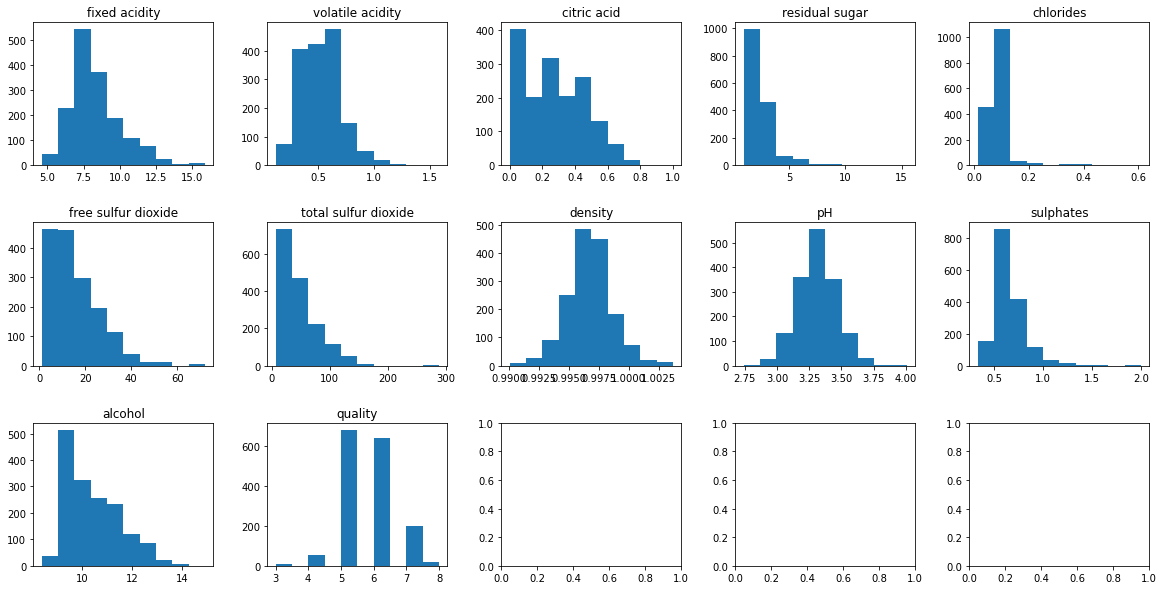

In [25]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (20,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for i in range(data.shape[1]):
    ax = axes.flat[i]
    ax.hist(data.iloc[:,i])
    ax.set_title(data.columns[i])

## Pre-process the data

1. Check missing data - none
2. Drop the irrelevant columns - unecessary in this case
3. Ensure data types are correct
3. Encode the categorical columns
4. Normalize the continuous columns
5. Put back the categorical and continuous columns together
6. Split the data into a training set and a validation set

In [26]:
# sometimes Python recognize int as str; also want to ensure the categorical data is int
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [27]:
# only continuous columns exist
X_all = data.drop('quality', axis = 1).values
X_all = (X_all - X_all.mean()) / X_all.std()
y_all = data['quality'].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)

# convert stuff to torch tensors so they can be used in PyTorch training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

## Define the neural network architecture

In [36]:
class ANNModel(nn.Module):

    def __init__(self, in_size, out_size, hidden_sizes, p):
        super().__init__()

        layerlist = []
        for i in hidden_sizes:
            layerlist.append(nn.Linear(in_size,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            #layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_size = i
        layerlist.append(nn.Linear(hidden_sizes[-1], out_size))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.layers(x)
        return x

## Define other stuff needed to train the neural network model

In [37]:
torch.manual_seed(33)

# output size = 1
model = ANNModel(X_train.shape[1], 1, [50, 50, 50], p = 0.4)

# for regression problem, use nn.MSELoss()
criterion = nn.MSELoss()

# the optimizer to find weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# feed the data into the model by batches
train_dataloader = DataLoader([(X_train[i,:], y_train[i]) for i in range(X_train.shape[0])],
                              batch_size=512, shuffle=True)

# number of times to train the model
epochs = 150 # higher number would result in over-fitting

# record the loss for each epoch
losses = []

## Train the model on training data

In [38]:
start_time = time.time()
for i in range(epochs):
    for j, (train_x, train_y) in enumerate(train_dataloader):
        # make a prediction
        y_pred = model(train_x)

        # calculate the loss and record it
        loss = criterion(y_pred, train_y.reshape(-1,1))
        if j == 0:
            losses.append(loss.detach().numpy())
            # a neat trick to save screen space:
            if i%(int(epochs/10)) == 1:
                print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        # set the gradients to zero
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # let the optimizer update the weights
        optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 31.37009430
epoch:  16  loss: 8.43126106
epoch:  31  loss: 2.82919502
epoch:  46  loss: 2.42434072
epoch:  61  loss: 2.37340832
epoch:  76  loss: 1.97615969
epoch:  91  loss: 2.13442159
epoch: 106  loss: 2.01666880
epoch: 121  loss: 2.10062551
epoch: 136  loss: 1.87202311
epoch: 149  loss: 1.94216907

Duration: 2 seconds


Text(0.5, 0, 'epoch')

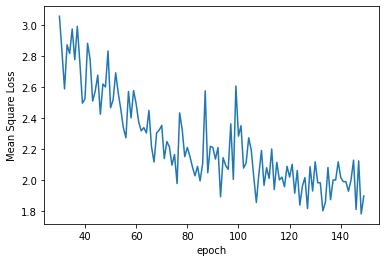

In [39]:
plt.plot(range(30, epochs), losses[30:])
plt.ylabel('Mean Square Loss')
plt.xlabel('epoch')

## Evaluate the model on the test set

In [40]:
# make sure to run model.eval(), or the random dropout will still be active
model.eval()
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'MSE Loss: {loss:.8f}')

MSE Loss: 0.71048403


C:\Users\ywang254\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.6, 0.1, 'Pearson corr = 0.456024')

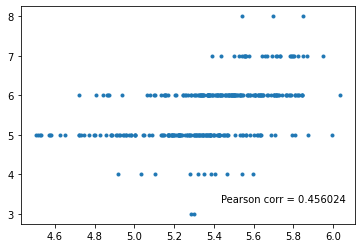

In [41]:
fig, ax = plt.subplots()
ax.plot(y_val, y_test, '.')
corr = np.corrcoef(y_val.numpy().reshape(-1), y_test.numpy())[0,1]
ax.text(0.6,0.1,f'Pearson corr = {corr:.6f}',transform = ax.transAxes)

## Save and re-load the model

In [42]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'RedWineModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# To load the model
model2 = ANNModel(X_train.shape[1], 1, [50, 50, 50], p = 0.4)
model2.load_state_dict(torch.load('RedWineModel.pt'))
model2.eval() # make sure to run this step!

# To make new predictions
with torch.no_grad():
    y_val = model2(X_test)
    loss = criterion(y_val, y_test.reshape(-1,1))
print(f'MSE Loss: {loss:.8f}')

MSE Loss: 0.50524539
